In [1]:
%%html
<marquee style='width: 50%; color: red;'><b>Всем привет!!!!! Рад вас тут видеть Оцените ноут</b></marquee>

In [2]:
# Author: Timur Abdualimov, SOVIET team
# Competition: Recommended system, SkillFctory
# First date code: 17.05.2020
# Used: Kaggle notebook, GPU!


import numpy as np
import pandas as pd 
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score, f1_score, precision_score, recall_score

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input, BatchNormalization
from keras.optimizers import Adam
from keras import metrics
from keras.utils.vis_utils import plot_model

import scikitplot as skplt

import sys
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
RANDOM_SEED = 13

print('Python       :', sys.version.split('\n')[0])
print('Pandas       :', pd.__version__)
print('Numpy        :', np.__version__)
print('Keras        :', keras.__version__)

Using TensorFlow backend.


/kaggle/input/recommendationsv4/train.csv
/kaggle/input/recommendationsv4/test_v3.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json
/kaggle/input/recommendationsv4/sample_submission.csv
/kaggle/input/soviet-rec-sys-daria-arie-pred/submission_surp.csv
/kaggle/input/soviet-rec-sys-daria-arie-pred/submission_LightFM_full2.csv
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Pandas       : 1.0.3
Numpy        : 1.18.1
Keras        : 2.3.1


In [3]:
def open_data():
    """ open datasets"""
    global train, test, sample_submission # объявляем переменные глобальными
    train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv', low_memory = False)
    train = train.drop_duplicates().reset_index(drop = True) # удалим дубликаты, если есть
    test = pd.read_csv('/kaggle/input/recommendationsv4/test_v3.csv', low_memory = False)
    sample_submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')
    
open_data() # открываем все и записываем датасет в переменные

def param_data(data): # посмотрим на данные
    """dataset required parameters """
    param = pd.DataFrame({
              'dtypes': data.dtypes.values,
              'nunique': data.nunique().values,
              'isna': data.isna().sum().values,
              'loc[0]': data.loc[0].values,
              }, 
             index = data.loc[0].index)
    return param

pd.concat([param_data(train), param_data(test)], 
          axis=1, 
          keys = [f'↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓ {train.shape}', f'↓ ТЕСТОВАЯ ВЫБОРКА ↓ {test.shape}'],  
          sort=False)

↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓ (826895, 12)                      \
                                           dtypes   nunique      isna   
verified                                     bool       2.0       0.0   
reviewTime                                 object    4580.0       0.0   
reviewerName                               object  101207.0     164.0   
reviewText                                 object  686739.0     274.0   
summary                                    object  411451.0     166.0   
unixReviewTime                              int64    4580.0       0.0   
vote                                       object     311.0  712944.0   
style                                      object   25892.0  398698.0   
image                                      object    6636.0  819916.0   
userid                                      int64  127448.0       0.0   
itemid                                      int64   41302.0       0.0   
rating                                    float64       2.0       0.0   
Unnamed: 0                                    NaN       NaN       NaN   
Id                                            NaN       NaN       NaN   

                                                                   \
                                                           loc[0]   
verified                                                     True   
reviewTime                                             10 4, 2016   
reviewerName                                              Heather   
reviewText      These are my FAVORITE spices in my collection....   
summary                           Must Add to your Spice kitchen!   
unixReviewTime                                         1475539200   
vote                                                          NaN   
style                                                         NaN   
image                                                         NaN   
userid                                                     102179   
itemid                                                      37138   
rating                                                          1   
Unnamed: 0                                                    NaN   
Id                                                            NaN   

               ↓ ТЕСТОВАЯ ВЫБОРКА ↓ (285965, 11)                      \
                                          dtypes   nunique      isna   
verified                                    bool       2.0       0.0   
reviewTime                                object    4349.0       0.0   
reviewerName                              object   86815.0      47.0   
reviewText                                   NaN       NaN       NaN   
summary                                      NaN       NaN       NaN   
unixReviewTime                             int64    4349.0       0.0   
vote                                      object     304.0  246503.0   
style                                     object   18904.0  138285.0   
image                                     object    2306.0  283597.0   
userid                                     int64  109357.0       0.0   
itemid                                     int64   37876.0       0.0   
rating                                       NaN       NaN       NaN   
Unnamed: 0                                 int64  285965.0       0.0   
Id                                         int64  285965.0       0.0   

                            
                    loc[0]  
verified              True  
reviewTime      10 1, 2016  
reviewerName     Rudys Mom  
reviewText             NaN  
summary                NaN  
unixReviewTime  1475280000  
vote                   NaN  
style                  NaN  
image                  NaN  
userid               68877  
itemid                7506  
rating                 NaN  
Unnamed: 0               0  
Id                       0

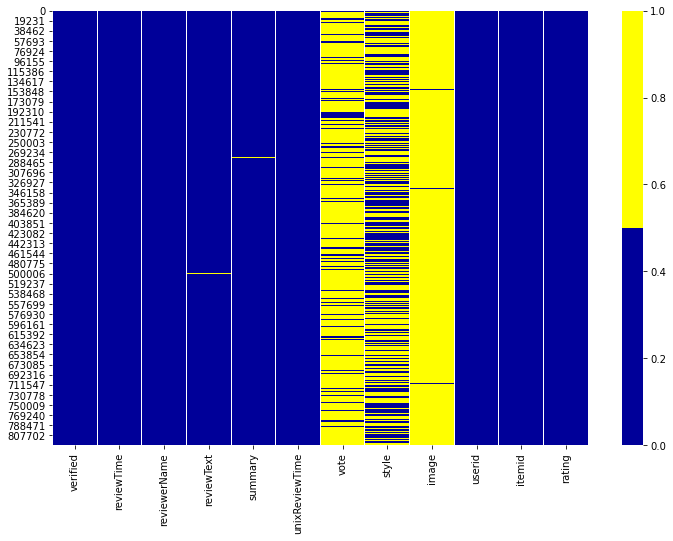

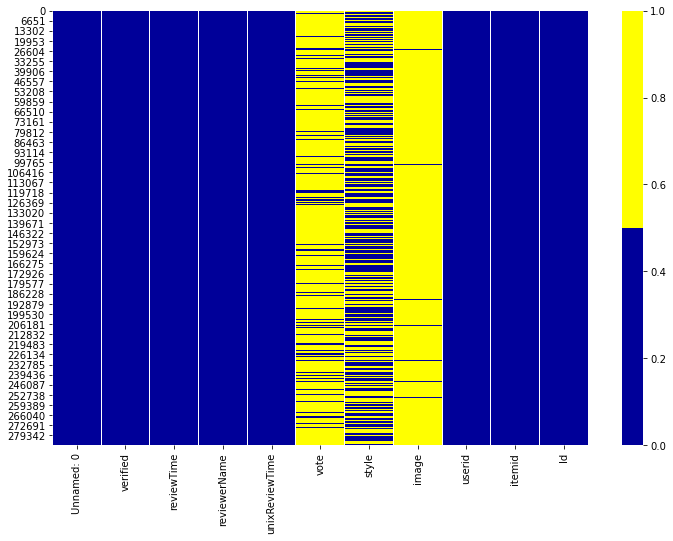

In [4]:
def viz_na(data):
    """NA visualisation"""
    global cols
    cols = data.columns # запишем названия строки сделаем переменную глобальной
    # определяем цвета 
    # желтый - пропущенные данные, синий - не пропущенные
    colours = ['#000099', '#ffff00'] 
    sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours))
    plt.show()


viz_na(train)
viz_na(test)

In [5]:
def stat_na_per_percent(data):
    print(f'{data.shape}')
    for col in data.columns:
        pct_missing = np.mean(data[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))
    print("END", end = '\n\n')
stat_na_per_percent(train)
stat_na_per_percent(test)

(826895, 12)
verified - 0.0%
reviewTime - 0.0%
reviewerName - 0.0%
reviewText - 0.0%
summary - 0.0%
unixReviewTime - 0.0%
vote - 86.0%
style - 48.0%
image - 99.0%
userid - 0.0%
itemid - 0.0%
rating - 0.0%
END

(285965, 11)
Unnamed: 0 - 0.0%
verified - 0.0%
reviewTime - 0.0%
reviewerName - 0.0%
unixReviewTime - 0.0%
vote - 86.0%
style - 48.0%
image - 99.0%
userid - 0.0%
itemid - 0.0%
Id - 0.0%
END



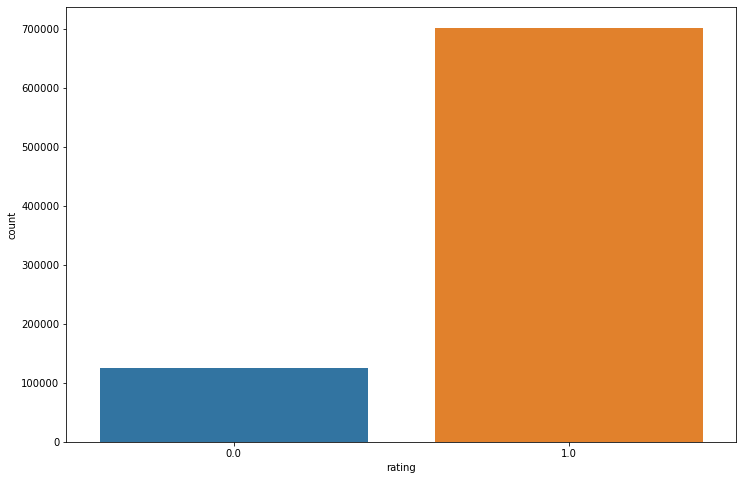

In [6]:
sns.countplot(train['rating']);

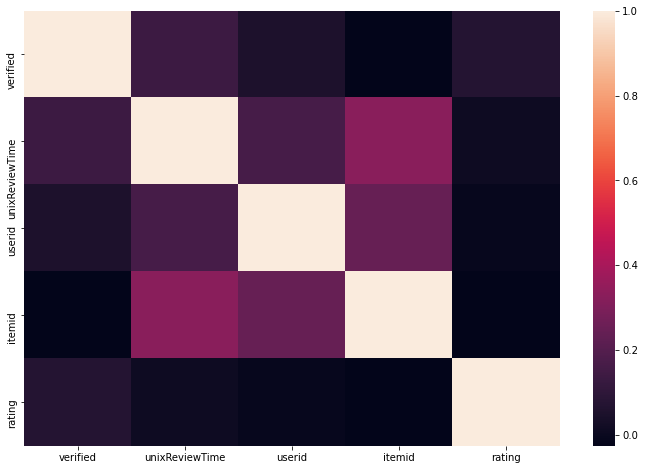

In [7]:
sns.heatmap(train.corr())
plt.show()

In [8]:
train_data_GB = pd.DataFrame({
    'userid': train['userid'],
    'itemid': train['itemid'],
    'rating': train['rating']
})

test_data_GB = pd.DataFrame({
    'userid': test['userid'],
    'itemid': test['itemid'],
})

train_data_GB = pd.get_dummies(train_data_GB, prefix='', prefix_sep='', columns=['rating'])

In [9]:
#train_data_GB['rating'] = train_data_GB['rating'].astype(int)
## unisue users, books
userid, utemid = len(train_data_GB.userid.unique()), len(train_data_GB.itemid.unique())


f'The dataset includes {len(train_data_GB)} ratings by {userid} unique users on {utemid} unique itemid.'

'The dataset includes 826895 ratings by 127448 unique users on 41302 unique itemid.'

In [10]:
train_, test_ = train_test_split(train_data_GB, test_size=0.01)
f"The training and testing data include {len(train), len(test)} records."

'The training and testing data include (826895, 285965) records.'

### Tabular data method

In [11]:
keras.backend.clear_session()
## define the number of latent factors (can be different for the users and books)
dim_embedding_user = 40
dim_embedding_book = 40

## book embedding
utem_input= Input(shape=[1], name='Utem')
utem_embedding = Embedding(utemid + 1, dim_embedding_book, name='Utem-Embedding')(utem_input)
utem_vec = Flatten(name='Utem-Flatten')(utem_embedding)
utem_vec = Dropout(0.5)(utem_vec)

## user embedding
user_input = Input(shape=[1], name='User')
user_embedding = Embedding(userid + 1, dim_embedding_user, name ='User-Embedding')(user_input)
user_vec = Flatten(name ='User-Flatten')(user_embedding)
user_vec = Dropout(0.5)(user_vec)

## concatenate flattened values 
concat = concatenate([utem_vec, user_vec])
concat_dropout = Dropout(0.5)(concat)

## add dense layer (can try more)
dense_1 = Dense(30, name ='Fully-Connected1', activation='relu')(concat)
dense_1 = Dense(30, name ='Fully-Connected2', activation='relu')(dense_1)
dense_1 = Dense(30, name ='Fully-Connected3', activation='relu')(dense_1)
dense_1 = Dense(30, name ='Fully-Connected4', activation='relu')(dense_1)
## define output (can try sigmoid instead of relu)
result = Dense(2, activation ='softmax',name ='Activation')(dense_1)

## define model with 2 inputs and 1 output
model_tabular = Model([user_input, utem_input], result)
model_tabular.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Utem (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Utem-Embedding (Embedding)      (None, 1, 40)        1652120     Utem[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 40)        5097960     User[0][0]                       
____________________________________________________________________________________________

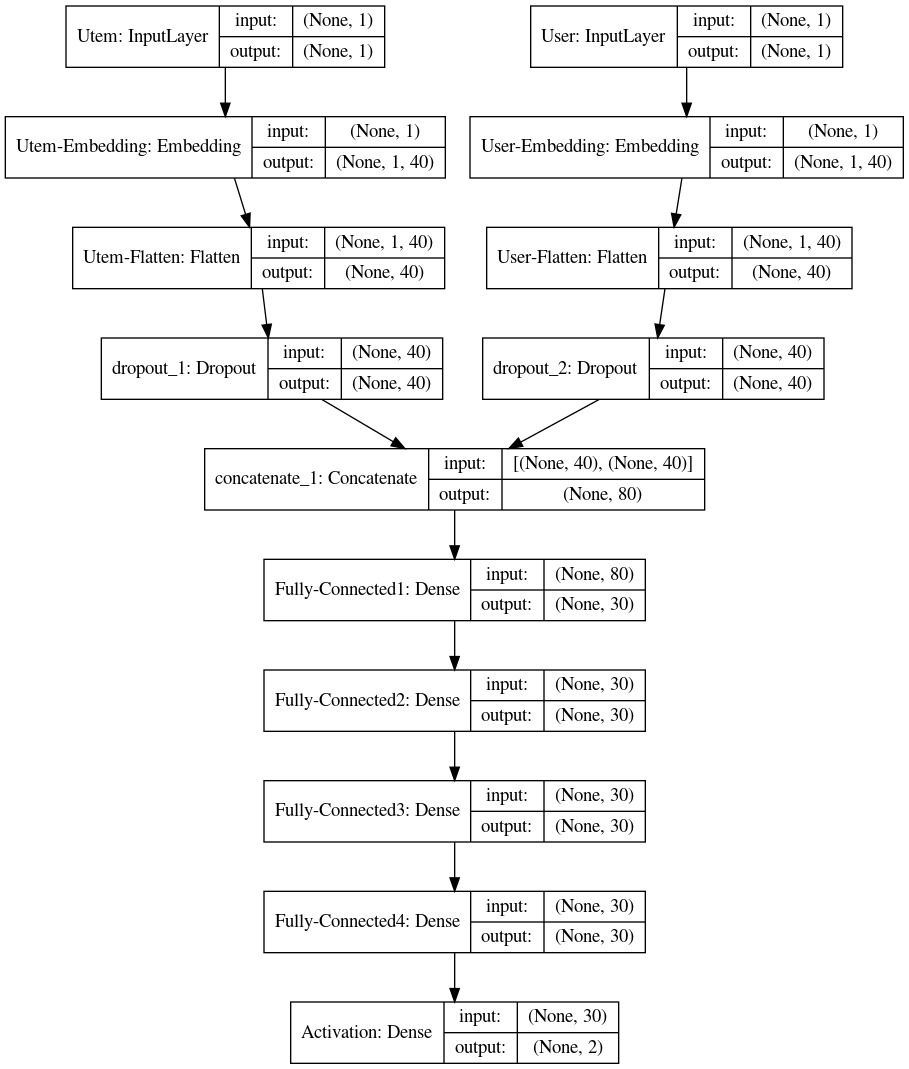

In [12]:
plot_model(model_tabular, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
## specify learning rate (or use the default by specifying optimizer = 'adam')
opt_adam = Adam(lr = 0.0003)

## compile model
model_tabular.compile(optimizer= opt_adam, loss= ['binary_crossentropy'], metrics=[keras.metrics.AUC()])

## fit model
history_tabular = model_tabular.fit([train_['userid'], train_['itemid']],
                                    train_.iloc[:,[-2,-1]],
                                    batch_size = 1000,
                                    validation_split = 0.1,
                                    epochs = 4,
                                    verbose = 1)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 736763 samples, validate on 81863 samples
Epoch 1/4
736763/736763 [==============================] - 8s 10us/step - loss: 0.4350 - auc_1: 0.8680 - val_loss: 0.3998 - val_auc_1: 0.8947
Epoch 2/4
736763/736763 [==============================] - 6s 8us/step - loss: 0.3645 - auc_1: 0.9170 - val_loss: 0.3827 - val_auc_1: 0.9064
Epoch 3/4
736763/736763 [==============================] - 7s 9us/step - loss: 0.3150 - auc_1: 0.9392 - val_loss: 0.3915 - val_auc_1: 0.9069
Epoch 4/4
736763/736763 [==============================] - 6s 9us/step - loss: 0.2899 - auc_1: 0.9486 - val_loss: 0.4081 - val_auc_1: 0.9061


In [14]:
test_pred_GB = model_tabular.predict([test_data_GB['userid'], test_data_GB['itemid']])[:,1]

In [15]:
test_pred = model_tabular.predict([test_['userid'], test_['itemid']])

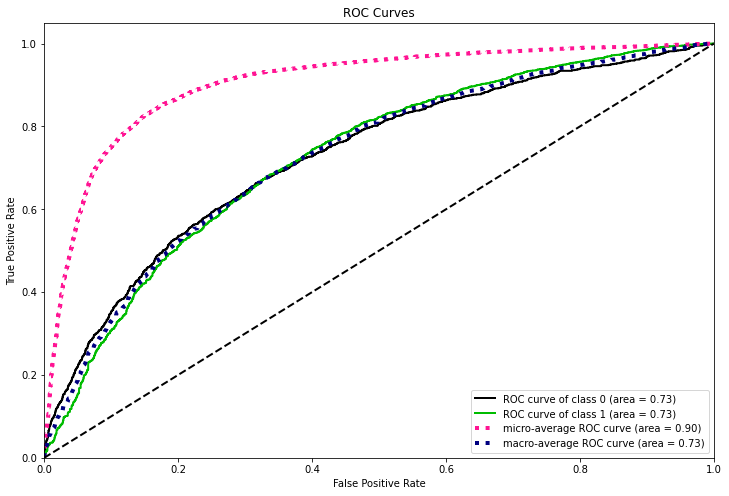

In [16]:
skplt.metrics.plot_roc(test_.iloc[:, -1], test_pred)
plt.show()

In [17]:
fpr, tpr, _ = roc_curve(test_.iloc[:, -1], test_pred[:,1])
auc = roc_auc_score(test_.iloc[:,  -1], test_pred[:, 1])
accuracy = accuracy_score(test_.iloc[:, -1], np.argmax(test_pred, axis = -1))
f1 = f1_score(test_.iloc[:, -1], np.argmax(test_pred, axis = -1))
precision =  precision_score(test_.iloc[:, -1], np.argmax(test_pred, axis = -1))
recall = recall_score(test_.iloc[:, -1], np.argmax(test_pred, axis = -1))

print('FP, TP              :', sum(fpr), sum(tpr))
print('ROC_AUC_SCORE       :', auc)
print('accuracy            :', accuracy)
print('precision           :', precision)
print('recall              :', recall)
print('f1                  :', f1)

FP, TP              : 839.5588470776613 1300.939173789174
ROC_AUC_SCORE       : 0.7282152787757272
accuracy            : 0.8373442979804088
precision           : 0.8742909906344809
recall              : 0.9441595441595442
f1                  : 0.9078830217108418


In [18]:
sample_submission['rating'] = test_pred_GB
sample_submission.to_csv('submission_XXXXXX.csv', index=False)
sample_submission.head(3)

,Id,rating
0,0,0.984592
1,1,0.978665
2,2,0.786765


In [19]:
#Эмбединги
utem_embedding_weights = model_tabular.layers[2].get_weights()[0]